# Customer segmentation (clustering)
## Hotel Customer Data
### This notebook was developed by:

- João Venichand - 20211644
- Gonçalo Custódio - 20211643
- Diogo Correia - 20211586
- Duarte Emanuel - 200564

### Data Description
Dataset related to customer behavior and preferences in a hotel context. Contains historical booking patterns, revenue data, and customer-specific preferences.

#### Customer Information:
- **ID**: Unique customer identifier (numeric)
- **Nationality**: Customer nationality (categorical: e.g., 'BRA', 'USA')
- **Age**: Customer age (numeric)
- **DaysSinceCreation**: Days since the customer account was created (numeric)
- **NameHash**: Anonymized hash of the customer’s name (text)
- **DocIDHash**: Anonymized hash of the customer’s ID document (text)
- **LodgingRevenue**: Total lodging revenue (numeric)
- **OtherRevenue**: Total revenue from non-lodging services (e.g., food, spa) (numeric)
- **MarketSegment**: Customer market segment (e.g., 'corporate', 'leisure') (categorical)

#### Booking Behaviour:
- **AverageLeadTime**: Average days between booking and arrival date (numeric)
- **BookingsCanceled**: Total canceled bookings by the customer (numeric)
- **BookingsNoShowed**: Total "no-show" bookings (numeric)
- **BookingsCheckedin**: Total bookings that resulted in stays (numeric)
- **PersonNights**: Total person-nights stayed (adults + children × nights) (numeric)
- **RoomNights**: Total room-nights stayed (rooms × nights) (numeric)
- **DistributionChannel**: Booking distribution channel (e.g., 'direct', 'agency') (categorical)

#### Customer Preferences (Binary: 0 = No, 1 = Yes)
- **SRHighFloor**: Requests rooms on higher floors
- **SRLowFloor**: Requests rooms on lower floors
- **SRMediumFloor**: Requests rooms on middle floors
- **SRAccessibleRoom**: Requests accessible rooms
- **SRBathtub**: Requests rooms with bathtubs
- **SRShower**: Requests rooms with showers
- **SRCrib**: Requests cribs
- **SRKingSizeBed**: Requests king-size beds
- **SRTwinBed**: Requests twin beds
- **SRNearElevator**: Requests rooms near elevators
- **SRAwayFromElevator**: Requests rooms away from elevators
- **SRNoAlcoholInMiniBar**: Requests mini-bars without alcohol
- **SRQuietRoom**: Requests quiet rooms

## Importing Libraries


__`Step 1`__ Import the required libraries.

In [60]:
import pandas as pd 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.ticker as ticker
import umap
from yellowbrick.cluster import SilhouetteVisualizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Understanding 


__`Step 2`__ Import the dataset, storing it in the data frame **data**.

In [61]:
data = pd.read_csv('Case1_HotelCustomerSegmentation.csv', sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

__`Step 3`__ Display the data.

In [62]:
data.head(5)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.0,53.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0xDA46E62F66936284DF2844EC4FC542D0DAD780C0EE0C...,0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93,240.0,60.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0xD2E3D5BFCA141865669F98D64CDA85AD04DEFF47F8A0...,0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


__`Step 4`__ Turn the ID into the index of the data.

In [63]:
if data['ID'].duplicated().any():
    print("There are duplicate IDs in the dataset.")
else:
    data.set_index('ID', inplace=True)
    print("customer_id has been successfully set as the index!")

customer_id has been successfully set as the index!


__`Step 5`__ Summary statistics for all variables

In [64]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
NameHash,111733,107584,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DocIDHash,110732,103480,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0
BookingsNoShowed,111733.0,NaN,NaN,NaN,0.0006,0.028217,0.0,0.0,0.0,0.0,3.0


__`Step 6`__ Check missing values

In [65]:
print(data.isnull().sum())

Nationality                0
Age                     4172
DaysSinceCreation          0
NameHash                   0
DocIDHash               1001
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64


In [66]:
binary_columns = ["SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"]

proportions = {}
for col in binary_columns:
    if col in data.columns:
        value_counts = data[col].value_counts(normalize=True) * 100
        proportions[col] = {
            'Percentagem de 0s': value_counts.get(0, 0),
            'Percentagem de 1s': value_counts.get(1, 0)
        }

percentage_df = pd.DataFrame(proportions).T
print(percentage_df)

                      Percentagem de 0s  Percentagem de 1s
SRHighFloor                   95.748794           4.251206
SRLowFloor                    99.869331           0.130669
SRAccessibleRoom              99.977625           0.022375
SRMediumFloor                 99.923031           0.076969
SRBathtub                     99.686753           0.313247
SRShower                      99.837112           0.162888
SRCrib                        98.381857           1.618143
SRKingSizeBed                 63.673221          36.326779
SRTwinBed                     84.318867          15.681133
SRNearElevator                99.966885           0.033115
SRAwayFromElevator            99.640214           0.359786
SRNoAlcoholInMiniBar          99.980310           0.019690
SRQuietRoom                   91.228196           8.771804


The only values ​​that are highly relevant are SRKKingSizeBed, SRTwinBed
The variables SRHighFloor, SRQuietRoom and SRCrib are somewhat relevant
All other variables are very low in 1

BookingsCanceled and BookingsNoShowed are not relevant, which leads us to believe that this is a positive aspect regarding the company. Therefore, our strategy will be to retain existing customers instead of trying to return customers who canceled or simply did not show up.

__`Step 7`__ Histograms of numeric variables

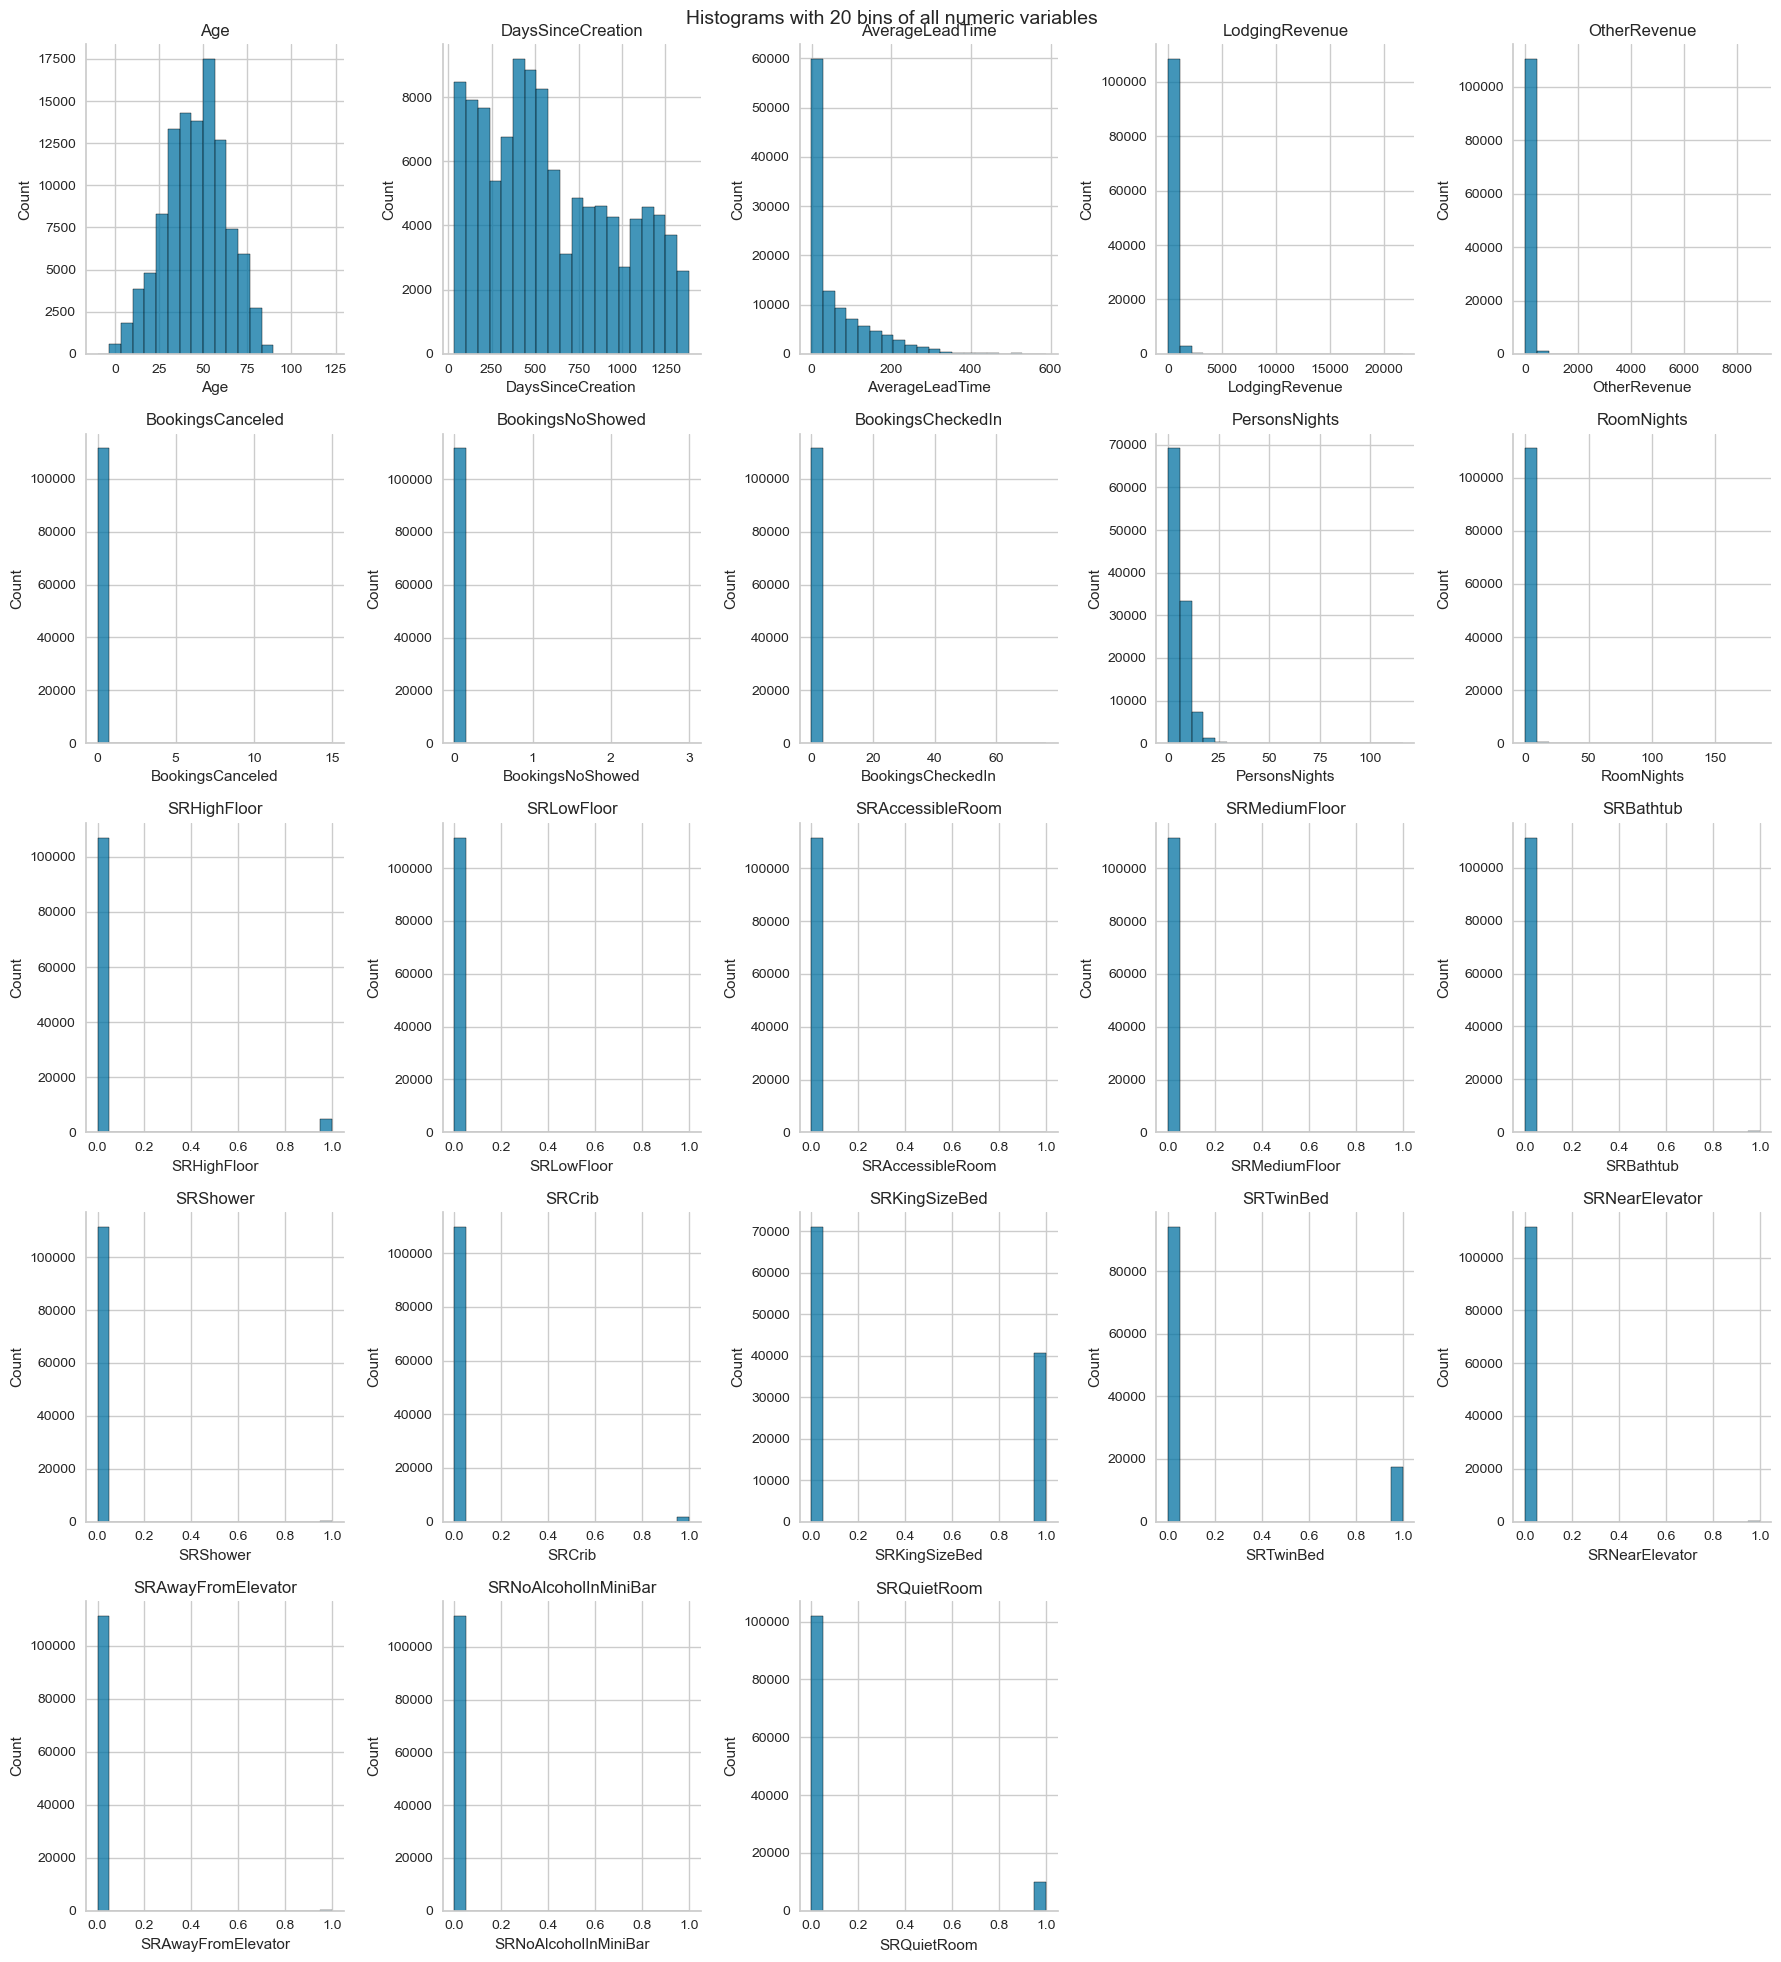

In [67]:
subPlots_label_fontSize = 12
plots_Title_fontSize = 14
numerical_data = data.select_dtypes(include=[np.number]).columns.tolist()
num_vars = len(numerical_data)
num_cols = 5
num_rows = (num_vars // num_cols) + (1 if num_vars % num_cols != 0 else 0)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.histplot(data=data,
                 bins=20,
                 x=var,
                 ax=ax[i],
                 kde=False)
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 8`__ Boxplot of numeric variables

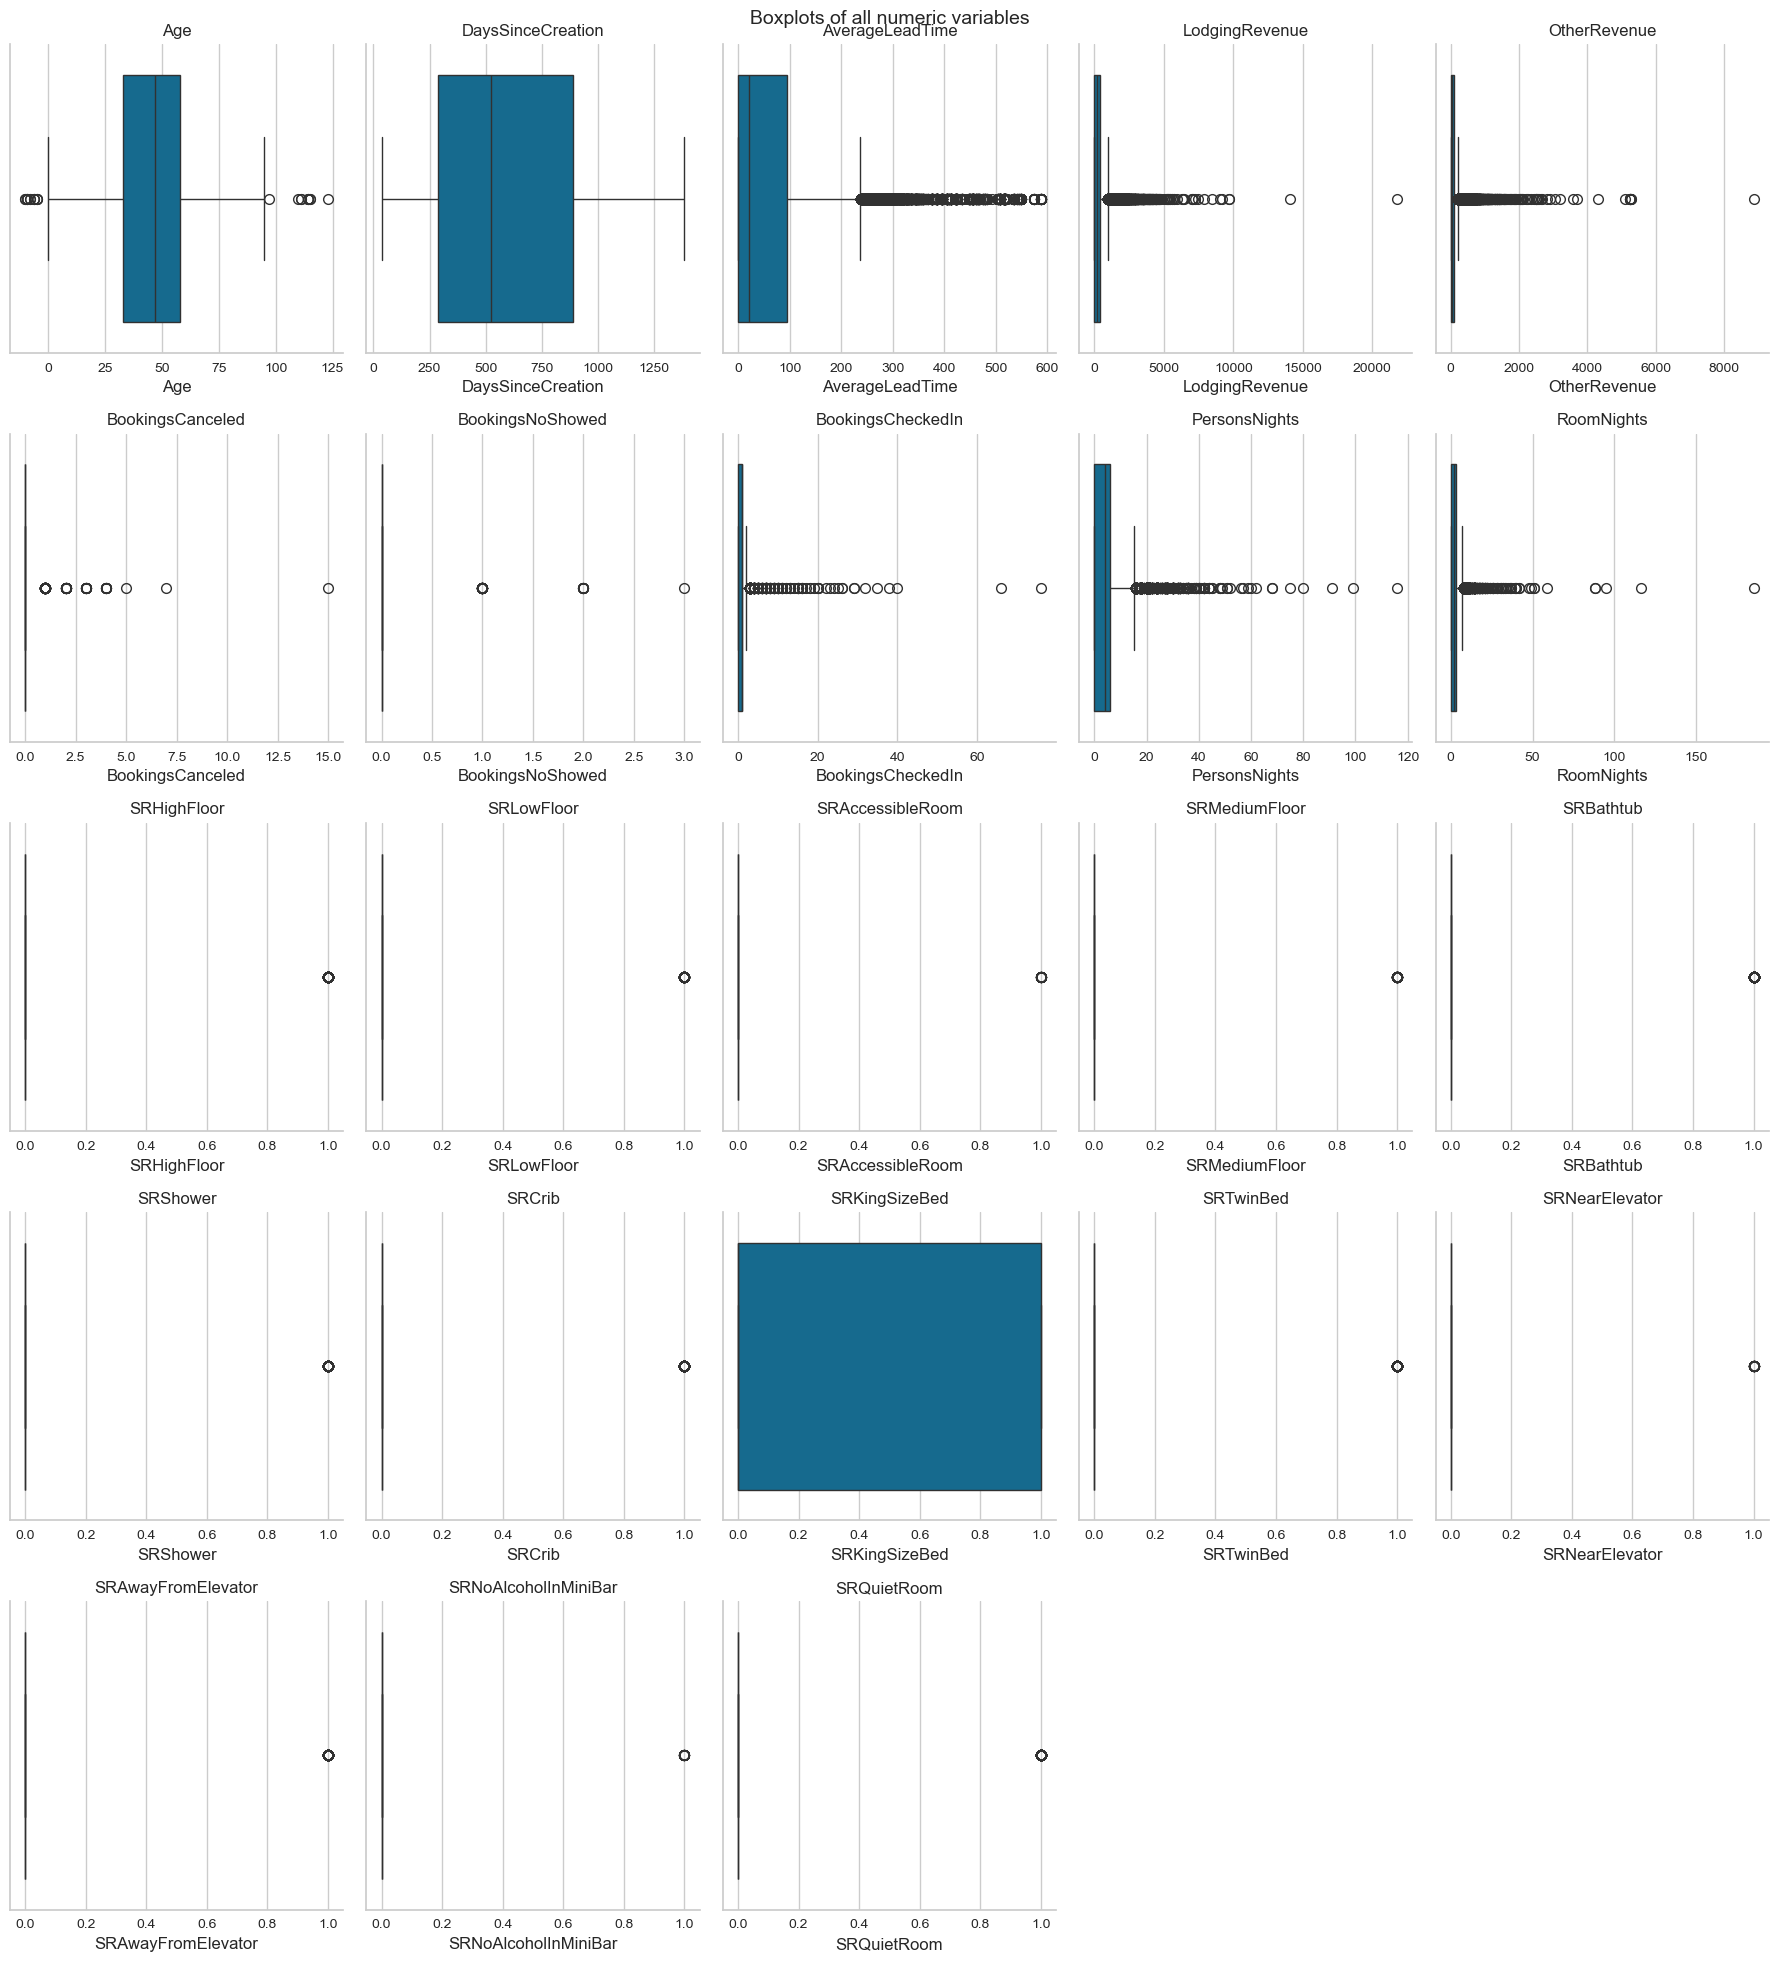

In [68]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.boxplot(data=data, x=var, ax=ax[i])
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 9`__ Check if the Customer Preferences have only binary values (0 or 1)

In [69]:
preferences_cols = [
    'SRHighFloor', 'SRLowFloor', 'SRMediumFloor', 'SRAccessibleRoom',
    'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed',
    'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom'
]

for col in preferences_cols:
    unique_values = data[col].unique()
    if not set(unique_values).issubset({0, 1}):
        print(f"Column {col} contains values other than 0 and 1: {unique_values}")

__`Step 10`__ Distribution of the variables with binary values (0 or 1)

In [70]:
for col in preferences_cols:
    print(f"Value counts for {col}:")
    print(data[col].value_counts(dropna=False))
    print("-" * 40)

Value counts for SRHighFloor:
SRHighFloor
0    106983
1      4750
Name: count, dtype: int64
----------------------------------------
Value counts for SRLowFloor:
SRLowFloor
0    111587
1       146
Name: count, dtype: int64
----------------------------------------
Value counts for SRMediumFloor:
SRMediumFloor
0    111647
1        86
Name: count, dtype: int64
----------------------------------------
Value counts for SRAccessibleRoom:
SRAccessibleRoom
0    111708
1        25
Name: count, dtype: int64
----------------------------------------
Value counts for SRBathtub:
SRBathtub
0    111383
1       350
Name: count, dtype: int64
----------------------------------------
Value counts for SRShower:
SRShower
0    111551
1       182
Name: count, dtype: int64
----------------------------------------
Value counts for SRCrib:
SRCrib
0    109925
1      1808
Name: count, dtype: int64
----------------------------------------
Value counts for SRKingSizeBed:
SRKingSizeBed
0    71144
1    40589
Name: cou

__`Step 11`__ Distribution of the categorical variables

In [71]:
ordered_columns = ['DistributionChannel', 'MarketSegment', 'Nationality', 'NameHash', 'DocIDHash']

for col in ordered_columns:
    print(f"Unique value counts for '{col}':")
    print(data[col].value_counts(dropna=False))
    print("-" * 40)

Unique value counts for 'DistributionChannel':
DistributionChannel
Travel Agent/Operator    91019
Direct                   16883
Corporate                 3135
GDS Systems                696
Name: count, dtype: int64
----------------------------------------
Unique value counts for 'MarketSegment':
MarketSegment
Other                    63680
Direct                   16363
Travel Agent/Operator    16353
Groups                   11461
Corporate                 2931
Complementary              657
Aviation                   288
Name: count, dtype: int64
----------------------------------------
Unique value counts for 'Nationality':
Nationality
FRA    16516
DEU    14805
PRT    14101
GBR    11462
ESP     6123
       ...  
BHS        1
TMP        1
TZA        1
PNG        1
BDI        1
Name: count, Length: 199, dtype: int64
----------------------------------------
Unique value counts for 'NameHash':
NameHash
0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51EF134B078B9D61A8CC4A    75
0xF1465EC9E

__`Step 12`__ Plot the distribution of categorical values

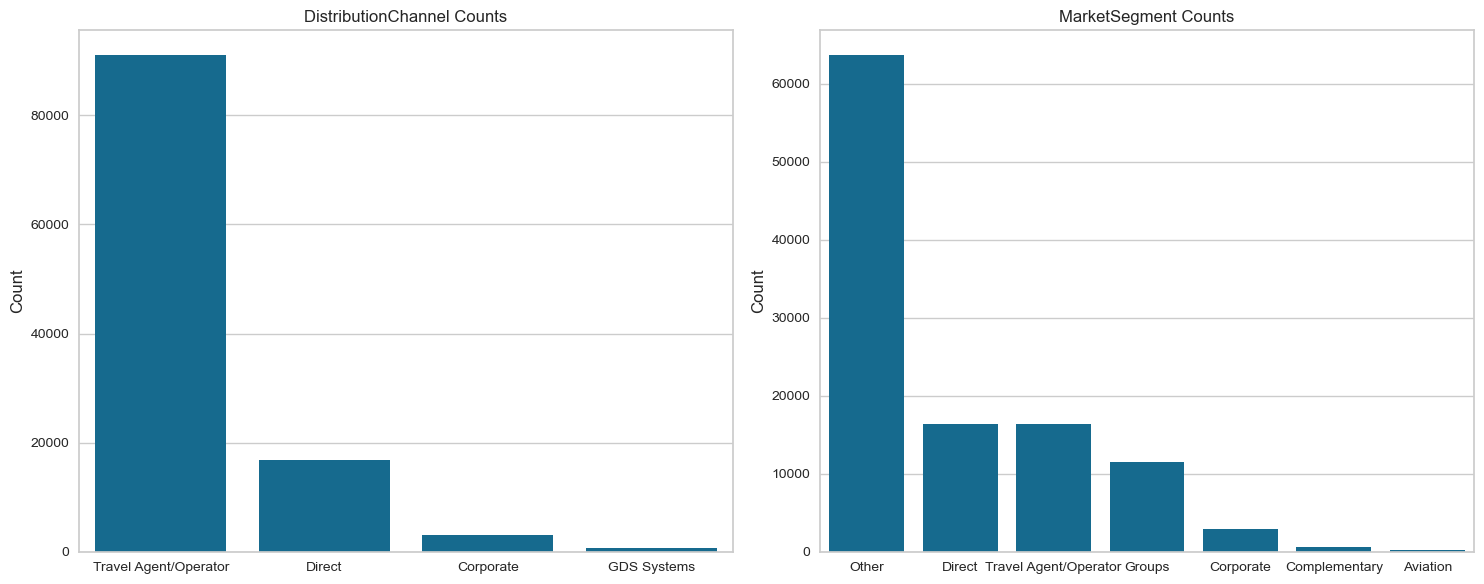

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
dist_order = data['DistributionChannel'].value_counts().index
market_order = data['MarketSegment'].value_counts().index

sns.countplot(data=data, x='DistributionChannel', ax=axes[0], order=dist_order)
axes[0].set_title("DistributionChannel Counts")
axes[0].set_xlabel("")
axes[0].set_ylabel("Count")
sns.countplot(data=data, x='MarketSegment', ax=axes[1], order=market_order)
axes[1].set_title("MarketSegment Counts")
axes[1].set_xlabel("")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

__`Step 12.1`__ Plot the distribution of categorical values

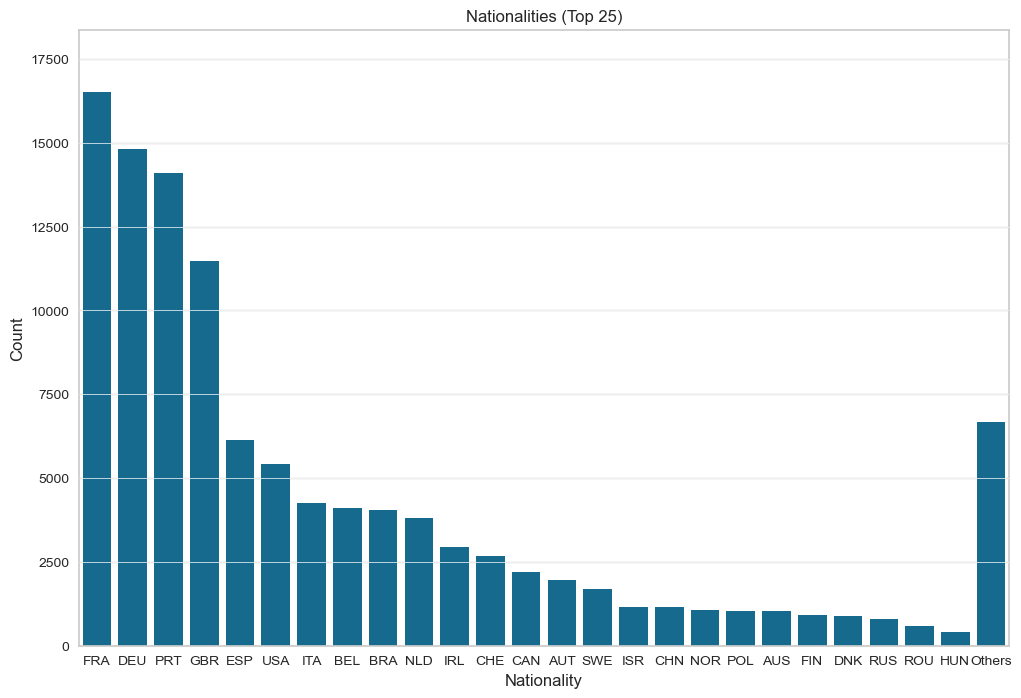

In [73]:
nat_counts = data['Nationality'].value_counts()
top_n = 25
top_nats = nat_counts.nlargest(top_n)
others = nat_counts.sum() - top_nats.sum()
sorted_top_nats = top_nats.sort_values(ascending=False)
others_series = pd.Series({'Others': others})
plot_data = pd.concat([sorted_top_nats, others_series])
order_list = list(sorted_top_nats.index) + ['Others']

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=order_list, y=plot_data[order_list].values)
max_count = plot_data.max()
y_ticks = range(0, int(max_count) + 2500, 2500)

for y in y_ticks:
    ax.axhline(y=y, color='white', linewidth=0.5, zorder=10)

plt.xlabel("Nationality")
plt.ylabel("Count")
plt.title("Nationalities (Top 25)")
plt.show()

In [74]:
print(data['BookingsNoShowed'].value_counts())

BookingsNoShowed
0    111676
1        48
2         8
3         1
Name: count, dtype: int64


In [75]:
print(data['BookingsCheckedIn'].value_counts())

BookingsCheckedIn
1     76474
0     33198
2      1634
3       201
4        57
5        33
7        30
6        19
9        13
8        12
10       12
15        7
11        7
16        5
13        5
20        4
12        3
29        2
26        2
18        2
40        1
22        1
24        1
19        1
25        1
14        1
23        1
76        1
66        1
32        1
17        1
38        1
35        1
Name: count, dtype: int64


# Data Preparation

### Missing Values Handling

In [76]:
data['Age'] = data['Age'].fillna(data['Age'].median())
data = data.dropna(subset=['DocIDHash'])

Testar o KNN ?

In [77]:
print(data.isnull().sum())

Nationality             0
Age                     0
DaysSinceCreation       0
NameHash                0
DocIDHash               0
AverageLeadTime         0
LodgingRevenue          0
OtherRevenue            0
BookingsCanceled        0
BookingsNoShowed        0
BookingsCheckedIn       0
PersonsNights           0
RoomNights              0
DistributionChannel     0
MarketSegment           0
SRHighFloor             0
SRLowFloor              0
SRAccessibleRoom        0
SRMediumFloor           0
SRBathtub               0
SRShower                0
SRCrib                  0
SRKingSizeBed           0
SRTwinBed               0
SRNearElevator          0
SRAwayFromElevator      0
SRNoAlcoholInMiniBar    0
SRQuietRoom             0
dtype: int64


Remove Negative Values

In [78]:
numerical_cols = data.select_dtypes(include=['number']).columns
data[numerical_cols] = data[numerical_cols].clip(lower=0)
negative_values = (data[numerical_cols] < 0).sum()

print("Negative values after correction:\n", negative_values)

Negative values after correction:
 Age                     0
DaysSinceCreation       0
AverageLeadTime         0
LodgingRevenue          0
OtherRevenue            0
BookingsCanceled        0
BookingsNoShowed        0
BookingsCheckedIn       0
PersonsNights           0
RoomNights              0
SRHighFloor             0
SRLowFloor              0
SRAccessibleRoom        0
SRMediumFloor           0
SRBathtub               0
SRShower                0
SRCrib                  0
SRKingSizeBed           0
SRTwinBed               0
SRNearElevator          0
SRAwayFromElevator      0
SRNoAlcoholInMiniBar    0
SRQuietRoom             0
dtype: int64


### Duplicate Values Handling

Handle Duplicate DocIDHash Entries

In [79]:
duplicated_clients = data['DocIDHash'].value_counts()
duplicated_clients = duplicated_clients[duplicated_clients > 1].index
data = data[~data['DocIDHash'].isin(duplicated_clients)]

print(f"Final dataset size after removing duplicate customers: {data.shape[0]} rows")

Final dataset size after removing duplicate customers: 100395 rows


Check BookingsCanceled and BookingsNoShowed

In [80]:
canceled_counts = data['BookingsCanceled'].value_counts()
no_show_counts = data['BookingsNoShowed'].value_counts()

print("Unique values and their counts in BookingsCanceled:")
print(canceled_counts, "\n")
print("Unique values and their counts in BookingsNoShowed:")
print(no_show_counts)

Unique values and their counts in BookingsCanceled:
BookingsCanceled
0    100354
1        34
2         4
3         3
Name: count, dtype: int64 

Unique values and their counts in BookingsNoShowed:
BookingsNoShowed
0    100385
1         9
2         1
Name: count, dtype: int64


*We will not use the variables BookingsCanceled and BookingsNoShowed because their distributions indicate that cancellations and no-shows are extremely rare events in our dataset. The vast majority of values are zero, while the occurrences of 1, 2, or 3 are minimal.*

### Outliers Handling

In [81]:
data = data[((data['Age'] >= 0) & (data['Age'] <= 100))]

Outliers in (PersonsNights < RoomNights)

In [82]:
invalid_rows = data[data['PersonsNights'] < data['RoomNights']]
data = data[data['PersonsNights'] >= data['RoomNights']]

print(f"Rows eliminated due to PersonsNights < RoomNights: {invalid_rows.shape[0]}")

Rows eliminated due to PersonsNights < RoomNights: 12


Non-Customer Group

In [83]:
valid_customers = data[
    (data['BookingsCheckedIn'] == 0) & 
    ((data['LodgingRevenue'] > 0) | (data['OtherRevenue'] > 0))
].copy()

print(f"Number of valid customers: {valid_customers.shape[0]}")

Number of valid customers: 0


In [84]:
profiles_no_checkin = data[data['BookingsCheckedIn'] == 0].copy()
data = data[data['BookingsCheckedIn'] != 0]

In [85]:
print(f"Number of profiles removed (no check-ins): {profiles_no_checkin.shape[0]}")
print(f"Number of profiles remaining: {data.shape[0]}")

Number of profiles removed (no check-ins): 30499
Number of profiles remaining: 69877


Analyse BookingsCheckedIn

In [86]:
checked_in_counts = data['BookingsCheckedIn'].value_counts()
print(checked_in_counts)

BookingsCheckedIn
1     68548
2      1183
3        94
4        16
5        14
11        4
7         4
8         3
10        3
6         2
9         2
12        1
26        1
13        1
15        1
Name: count, dtype: int64


Cap and Log Transformation

In [87]:
data['LodgingRevenue'] = data['LodgingRevenue'].clip(upper=6000)
data['OtherRevenue'] = data['OtherRevenue'].clip(upper=3000)
data['AverageLeadTime'] = data['AverageLeadTime'].clip(upper=300)
data['PersonsNights'] = data['PersonsNights'].clip(upper=35)
data['RoomNights'] = data['RoomNights'].clip(upper=30)

"""Se vale a pena meter a mediana para os valores extremos"""
"""Testar com o LodgingRevenue_Log tirar os valores zero"""

data["LodgingRevenue_Log"] = np.log1p(data["LodgingRevenue"])
data['OtherRevenue_Log'] = np.log1p(data['OtherRevenue'])
data['AverageLeadTime_Log'] = np.log1p(data['AverageLeadTime'])
data['PersonsNights_Log'] = np.log1p(data['PersonsNights'])
data['RoomNights_Log'] = np.log1p(data['RoomNights'])

In [88]:
data.drop(columns=['LodgingRevenue', 'OtherRevenue', 'AverageLeadTime', 'PersonsNights', 'RoomNights'], inplace=True)

IQR Method

In [89]:
"""numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

data = remove_outliers_iqr(data, numerical_cols)
print(f"Dataset size after IQR-based outlier removal: {data.shape[0]} rows")"""

'numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()\n\ndef remove_outliers_iqr(df, columns):\n    for col in columns:\n        Q1 = df[col].quantile(0.25)\n        Q3 = df[col].quantile(0.75)\n        IQR = Q3 - Q1\n        lower_bound = Q1 - 1.5 * IQR\n        upper_bound = Q3 + 1.5 * IQR\n        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]\n    return df\n\ndata = remove_outliers_iqr(data, numerical_cols)\nprint(f"Dataset size after IQR-based outlier removal: {data.shape[0]} rows")'

# Outliers Check

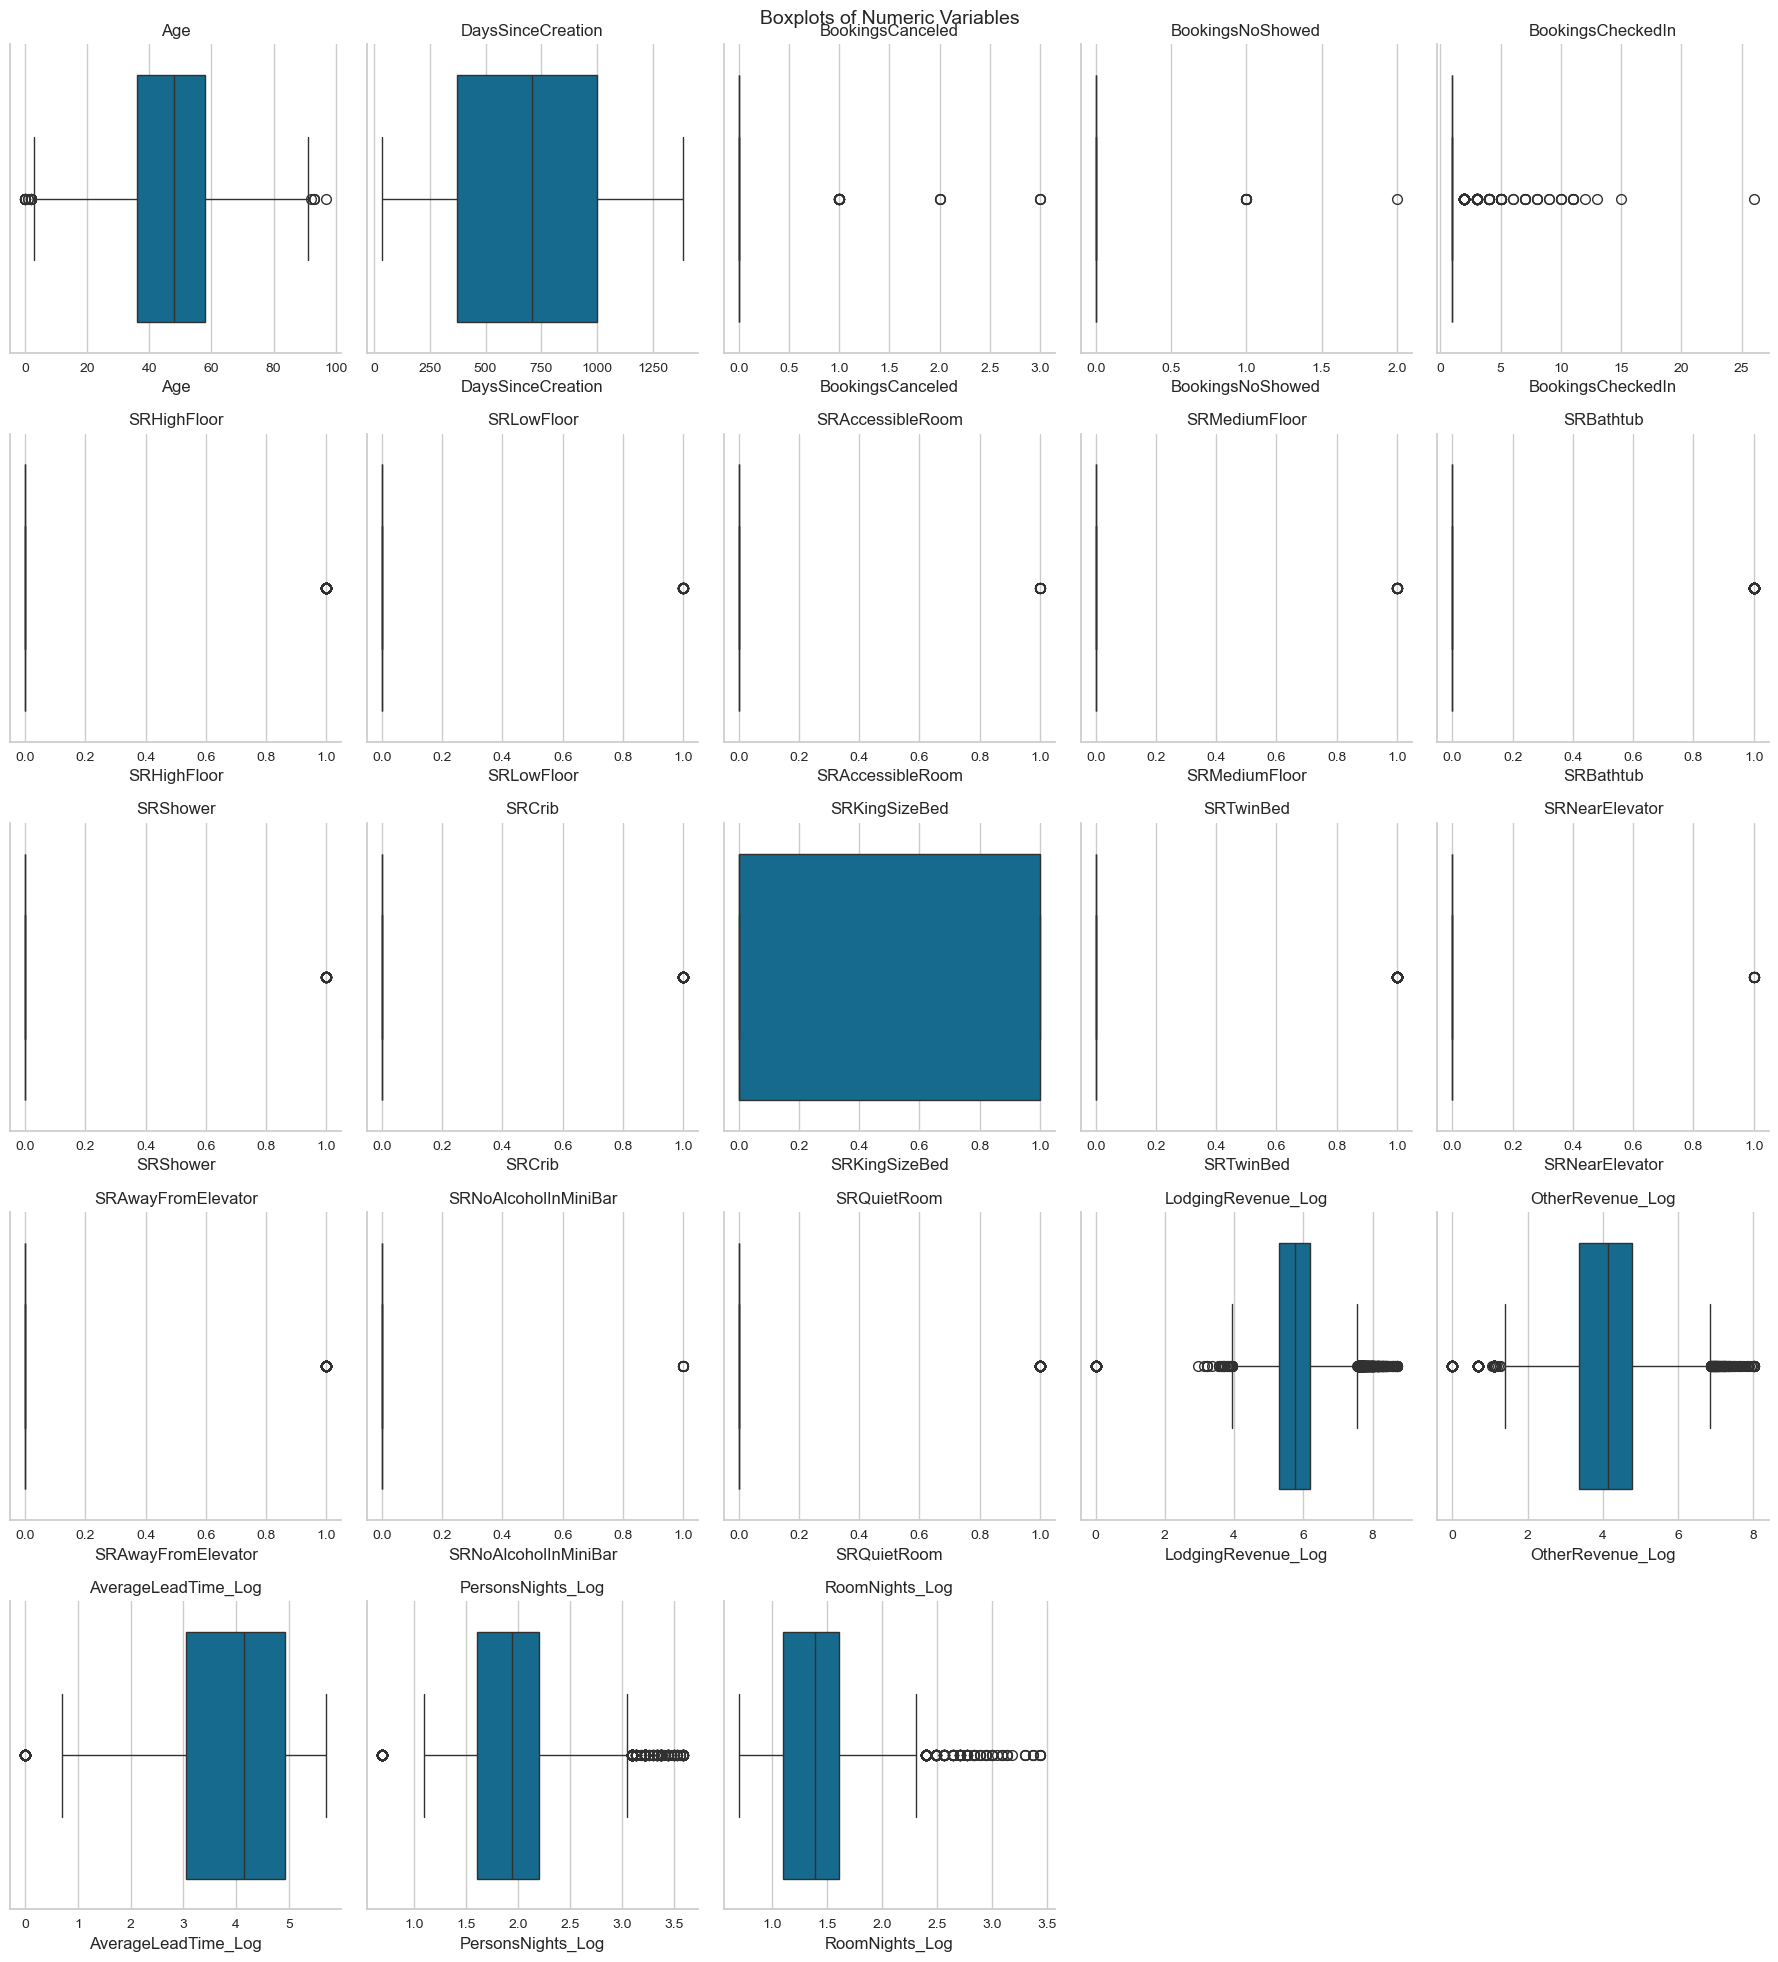

In [90]:
numerical_data = data.select_dtypes(include=[np.number]).columns.tolist()
num_vars = len(numerical_data)
num_cols = 5
num_rows = (num_vars // num_cols) + (1 if num_vars % num_cols != 0 else 0)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.boxplot(data=data, x=var, ax=ax[i])
    ax[i].set_title(var, fontsize=12)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
plt.suptitle("Boxplots of Numeric Variables", fontsize=14)
plt.tight_layout()
plt.show()

1️⃣ Re-run IQR filtering on the log-transformed featuresv

2️⃣ Use epsilon = 1e-3 for zero-value handling in logs

3️⃣ Consider Winsorization instead of clip() for smoother capping

# Scaling

In [91]:
"""# Update feature list to use log-transformed versions
features_to_scale = [
    'Age', 'DaysSinceCreation', 'BookingsCheckedIn', 
    'LodgingRevenue_Log', 'OtherRevenue_Log', 'AverageLeadTime_Log', 
    'PersonsNights_Log', 'RoomNights_Log'
]

# Select only available features
available_features = [col for col in features_to_scale if col in data.columns]

# Apply StandardScaler
scaler = StandardScaler()
data[available_features] = scaler.fit_transform(data[available_features])"""

"# Update feature list to use log-transformed versions\nfeatures_to_scale = [\n    'Age', 'DaysSinceCreation', 'BookingsCheckedIn', \n    'LodgingRevenue_Log', 'OtherRevenue_Log', 'AverageLeadTime_Log', \n    'PersonsNights_Log', 'RoomNights_Log'\n]\n\n# Select only available features\navailable_features = [col for col in features_to_scale if col in data.columns]\n\n# Apply StandardScaler\nscaler = StandardScaler()\ndata[available_features] = scaler.fit_transform(data[available_features])"

# Correlations

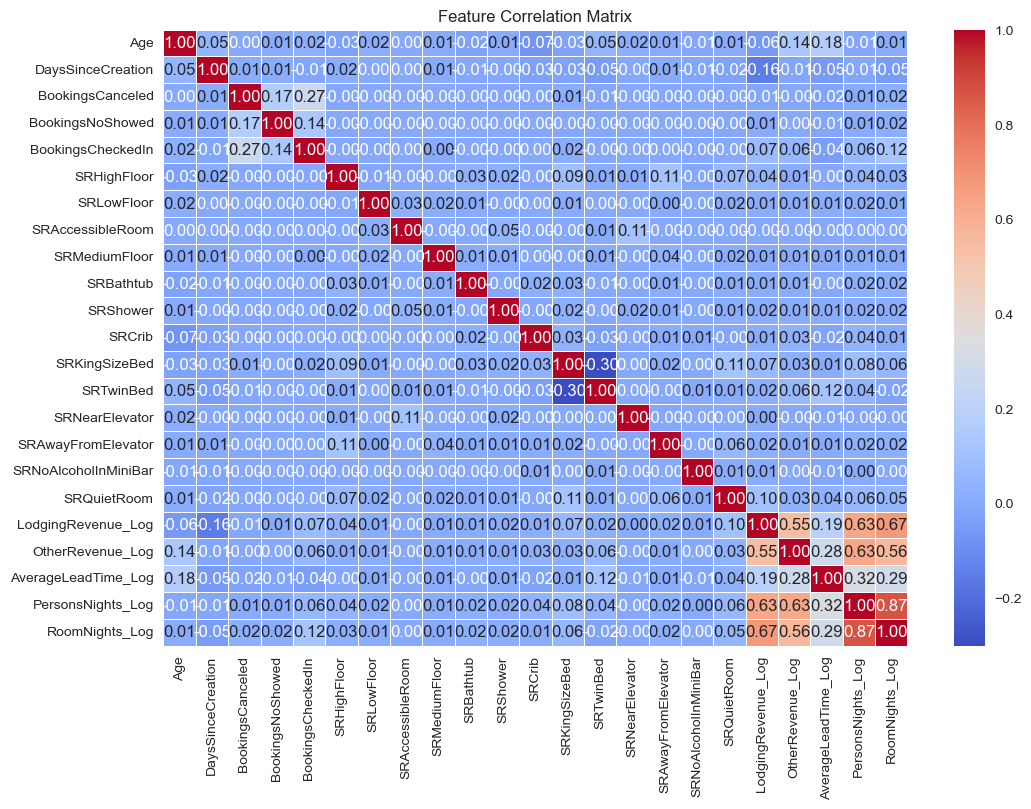

In [92]:
numerical_cols = data.select_dtypes(include=['number']).columns
corr_matrix = data[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

### Merge Features based on the Correlation

In [93]:
data["TotalNights_Log"] = data["PersonsNights_Log"] + data["RoomNights_Log"]
data.drop(columns=["PersonsNights_Log", "RoomNights_Log"], inplace=True)

In [94]:
data["TotalRevenue_Log"] = data["LodgingRevenue_Log"] + data["OtherRevenue_Log"]
data.drop(columns=["LodgingRevenue_Log", "OtherRevenue_Log"], inplace=True)

Testar se ao fazer merge destas 2 novas features vai influenciar o clustering

# One-Hot Encoding (Categorical Variables)

In [95]:
data = pd.get_dummies(data, columns=['DistributionChannel'], drop_first=False)

print("One-Hot Encoding applied successfully!")

One-Hot Encoding applied successfully!


In [96]:
encoded_distribution = data.filter(like='DistributionChannel').sum()

print("Count of 1s in One-Hot Encoded Nationality Variables:\n", encoded_distribution)

Count of 1s in One-Hot Encoded Nationality Variables:
 DistributionChannel_Corporate                 1636
DistributionChannel_Direct                    9107
DistributionChannel_GDS Systems                486
DistributionChannel_Travel Agent/Operator    58648
dtype: int64


### "Nationality" Handling

In [97]:
filtered_data = data[data['Nationality'] != 'Other']
nationality_counts = filtered_data['Nationality'].value_counts(normalize=True) * 100
threshold_value = nationality_counts[nationality_counts > 7.5].index  

data['Nationality_Processed'] = data['Nationality'].apply(
    lambda x: x if x in threshold_value else 'Other'
)

data = pd.get_dummies(data, columns=['Nationality_Processed'], drop_first=False)

Testar com cumulative distribution

In [98]:
"""# Calculate cumulative distribution
cumulative_threshold = 0.90  # Keep nationalities covering 90% of customers
nationality_counts = data["Nationality"].value_counts(normalize=True)
cumulative_counts = nationality_counts.cumsum()
selected_nationalities = cumulative_counts[cumulative_counts <= cumulative_threshold].index

# Apply the new dynamic threshold
data["Nationality_Processed"] = data["Nationality"].apply(lambda x: x if x in selected_nationalities else "Other")

# One-Hot Encoding
data = pd.get_dummies(data, columns=["Nationality_Processed"], drop_first=False)
"""

'# Calculate cumulative distribution\ncumulative_threshold = 0.90  # Keep nationalities covering 90% of customers\nnationality_counts = data["Nationality"].value_counts(normalize=True)\ncumulative_counts = nationality_counts.cumsum()\nselected_nationalities = cumulative_counts[cumulative_counts <= cumulative_threshold].index\n\n# Apply the new dynamic threshold\ndata["Nationality_Processed"] = data["Nationality"].apply(lambda x: x if x in selected_nationalities else "Other")\n\n# One-Hot Encoding\ndata = pd.get_dummies(data, columns=["Nationality_Processed"], drop_first=False)\n'

In [99]:
encoded_nationality_counts = data.filter(like='Nationality_Processed_').sum()

print("Count of 1s in One-Hot Encoded Nationality Variables:\n", encoded_nationality_counts)

Count of 1s in One-Hot Encoded Nationality Variables:
 Nationality_Processed_DEU      10002
Nationality_Processed_FRA      11008
Nationality_Processed_GBR       7597
Nationality_Processed_Other    34889
Nationality_Processed_PRT       6381
dtype: int64


# Feature Selection

In [100]:
print("List of variables in the dataset:\n")
for col in data.columns:
    print(col)

List of variables in the dataset:

Nationality
Age
DaysSinceCreation
NameHash
DocIDHash
BookingsCanceled
BookingsNoShowed
BookingsCheckedIn
MarketSegment
SRHighFloor
SRLowFloor
SRAccessibleRoom
SRMediumFloor
SRBathtub
SRShower
SRCrib
SRKingSizeBed
SRTwinBed
SRNearElevator
SRAwayFromElevator
SRNoAlcoholInMiniBar
SRQuietRoom
AverageLeadTime_Log
TotalNights_Log
TotalRevenue_Log
DistributionChannel_Corporate
DistributionChannel_Direct
DistributionChannel_GDS Systems
DistributionChannel_Travel Agent/Operator
Nationality_Processed_DEU
Nationality_Processed_FRA
Nationality_Processed_GBR
Nationality_Processed_Other
Nationality_Processed_PRT


In [101]:
columns_to_drop = [
    'NameHash', 'DocIDHash', 'BookingsCanceled', 'BookingsNoShowed', 'MarketSegment',
    'SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor', 'SRBathtub',
    'SRShower', 'SRCrib', 'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', "Nationality"
]

data.drop(columns=columns_to_drop, inplace=True)

In [102]:
print("List of variables in the dataset:\n")
for col in data.columns:
    print(col)

List of variables in the dataset:

Age
DaysSinceCreation
BookingsCheckedIn
SRKingSizeBed
SRTwinBed
SRQuietRoom
AverageLeadTime_Log
TotalNights_Log
TotalRevenue_Log
DistributionChannel_Corporate
DistributionChannel_Direct
DistributionChannel_GDS Systems
DistributionChannel_Travel Agent/Operator
Nationality_Processed_DEU
Nationality_Processed_FRA
Nationality_Processed_GBR
Nationality_Processed_Other
Nationality_Processed_PRT


### Min Max Scaling for the selected Features

In [103]:
scaler = MinMaxScaler()
data[:] = scaler.fit_transform(data)

### PCA

C:\Users\gonca\AppData\Local\Temp\ipykernel_33292\4173087758.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca2[:, 0], X_pca2[:, 1], edgecolor='none', alpha=0.5, cmap='viridis')


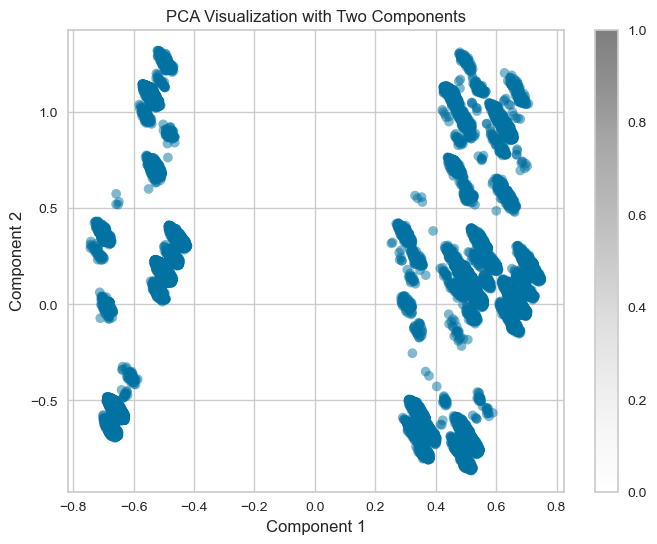

In [104]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(data)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("PCA Visualization with Two Components")
plt.colorbar()
plt.show()

In [105]:
pca = PCA().fit(data)
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({
    'Component': range(1, len(data.columns) + 1),
    'Variance explained': pcaevr,
    'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)
})

pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.199231,0.199231
1,2,0.171621,0.370852
2,3,0.141932,0.512784
3,4,0.093102,0.605886
4,5,0.075536,0.681423
5,6,0.070892,0.752315
6,7,0.059409,0.811724
7,8,0.048148,0.859872
8,9,0.045852,0.905724
9,10,0.034936,0.940660


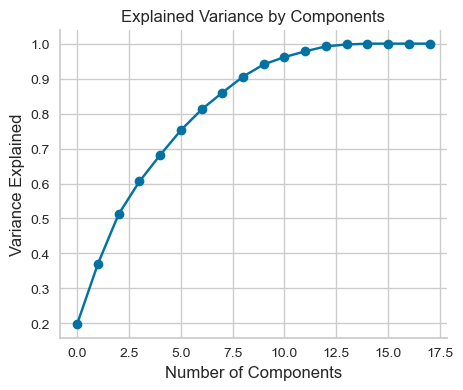

In [106]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
sns.despine()
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Components')
plt.show()

In [107]:
pca_reduced = PCA(n_components=10)
pca_reduced.fit(data)
X_pca_reduced = pca_reduced.transform(data) 
print(X_pca_reduced.shape)

(69877, 10)


# Clustering

### K-Means

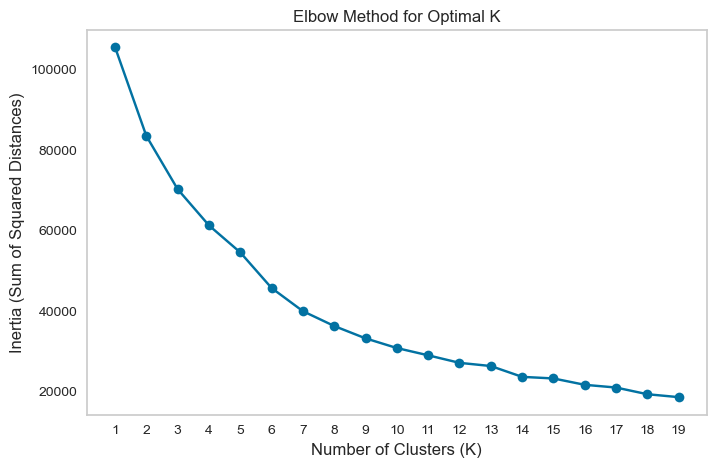

In [108]:
k_values = range(1, 20)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans.fit(X_pca_reduced)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.xticks(k_values)
plt.grid()
plt.show()

K = 5 is the best choice based on the elbow method

In [109]:
"""sil = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=123).fit(X_pca_reduced)
    labels = km.labels_
    sil.append(silhouette_score(X_pca_reduced, labels, metric='euclidean'))

fig, ax = plt.subplots(figsize=(5, 4))
plt.plot(range(2, 10), sil, 'bx-')

sns.despine()
fmt = "{x:,.2f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method - Reduced Dimensionality')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()"""

'sil = []\n\nfor k in range(2, 10):\n    km = KMeans(n_clusters=k, random_state=123).fit(X_pca_reduced)\n    labels = km.labels_\n    sil.append(silhouette_score(X_pca_reduced, labels, metric=\'euclidean\'))\n\nfig, ax = plt.subplots(figsize=(5, 4))\nplt.plot(range(2, 10), sil, \'bx-\')\n\nsns.despine()\nfmt = "{x:,.2f}"\ntick = ticker.StrMethodFormatter(fmt)\nax.yaxis.set_major_formatter(tick)\nplt.xlabel(\'K\')\nplt.ylabel(\'Silhouette Score\')\nplt.title(\'Silhouette Method - Reduced Dimensionality\')\nax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))\nplt.show()'

In [110]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=123)
allDistances = kmeans.fit_transform(X_pca_reduced)
y_kmeans = kmeans.predict(X_pca_reduced)

### Check Cluster Distributions

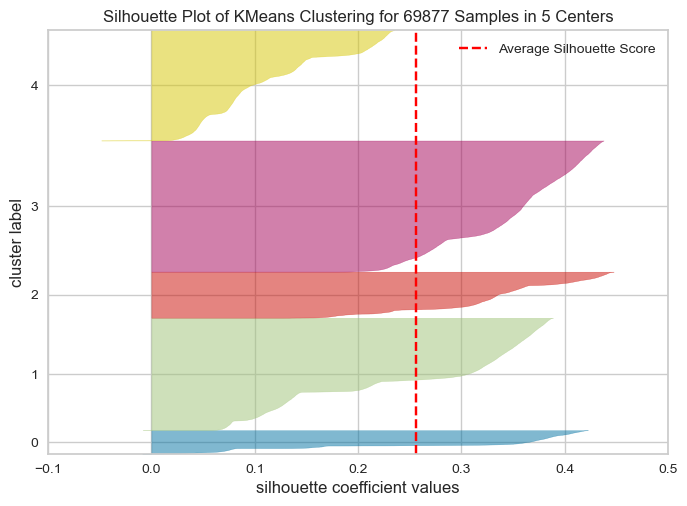

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 69877 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [111]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_pca_reduced)
visualizer.show()

Cluster Distribution:
 0     3875
1    18562
2     7597
3    21653
4    18190
Name: count, dtype: int64


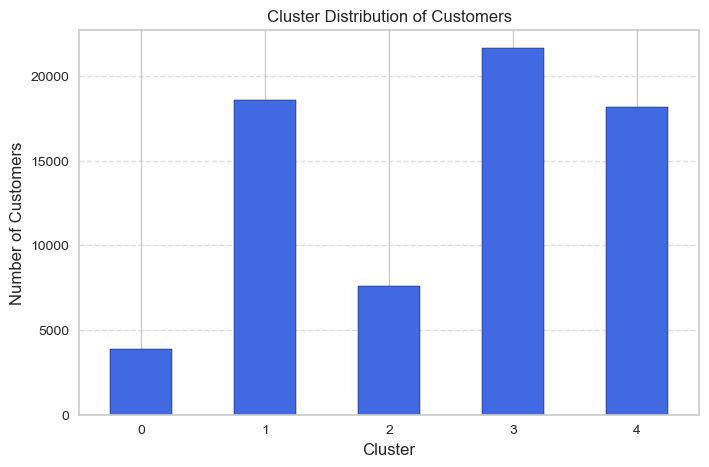

In [112]:
cluster_counts = pd.Series(y_kmeans).value_counts().sort_index()

print("Cluster Distribution:\n", cluster_counts)

plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='royalblue', edgecolor='black')
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Cluster Distribution of Customers")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1️⃣ Cluster Distribution Insights
- The bar chart shows that some clusters are much larger than others.
- Cluster 3 has the highest number of points (~21,653), while Cluster 0 is the smallest (~3,875).
- The difference in cluster sizes might indicate an imbalance, meaning some groups are more general while others capture specific patterns.

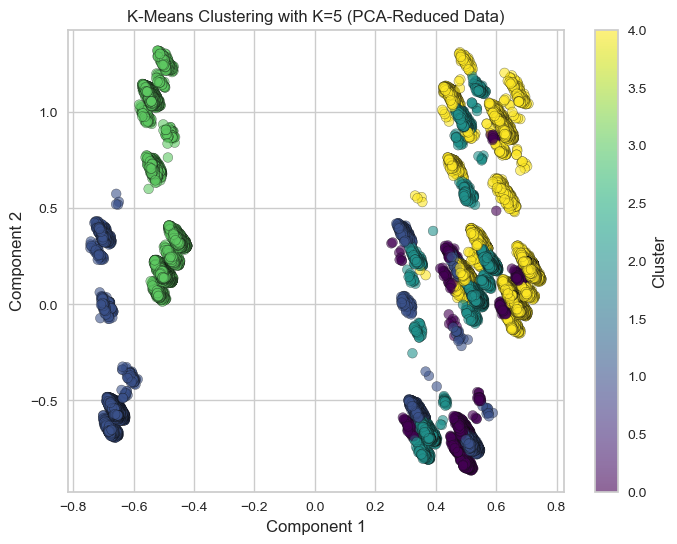

In [113]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y_kmeans, cmap='viridis', edgecolor='k', alpha=0.6)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'K-Means Clustering with K={K} (PCA-Reduced Data)')
plt.colorbar(label="Cluster")
plt.show()

# UMAP

In [114]:
umap_reducer = umap.UMAP(n_components=2, random_state=123)
X_umap = umap_reducer.fit_transform(X_pca_reduced)

print("UMAP-reduced shape:", X_umap.shape)

c:\Users\gonca\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP-reduced shape: (69877, 2)


In [115]:
kmeans_umap = KMeans(n_clusters=K, random_state=123)
y_kmeans_umap = kmeans_umap.fit_predict(X_umap)

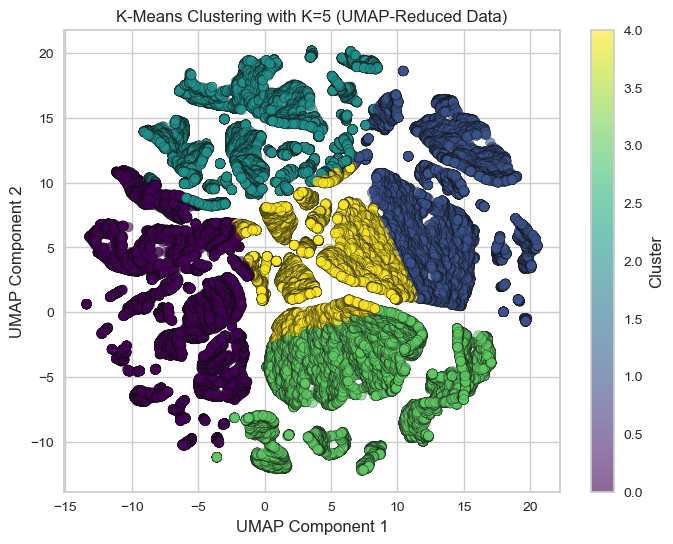

In [116]:
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_kmeans_umap, cmap='viridis', edgecolor='k', alpha=0.6)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title(f'K-Means Clustering with K={K} (UMAP-Reduced Data)')
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
"""
Analisar os CLusters: Estatisticas, visualizar e finalmente descrever
"""